In [1]:
import sys, os
sys.path.insert(0, os.path.join("..", ".."))

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np

import open_cp.network
import open_cp.network_hotspot
import open_cp.sources.chicago
import open_cp.geometry

# Geometry reduction

This notebook is some musings on [combinatorial explosion](https://en.wikipedia.org/wiki/Combinatorial_explosion) problems I am having.

A problem we run into is that our graph algorithms are:
- Slow.  Massively not helped by a pure Python implementation
- We end up considering huge numbers of paths.

Let's look more closely at the graphs.  Suppose we "topologically reduce" the graph: delete any vertex which has just two neighbours.  This does not change the search we need to perform when assigning risk, but it does decrease the number of edges and vertices in the graph.  **On second thoughts** this didn't seem to help that much.

In [2]:
with open("Case study Chicago/input.graph", "rb") as f:
    graph = open_cp.network.PlanarGraph.from_bytes(f.read())

In [3]:
reduced = open_cp.network.simple_reduce_graph(graph)

In [4]:
graph.number_edges, reduced.number_edges

(40068, 9771)

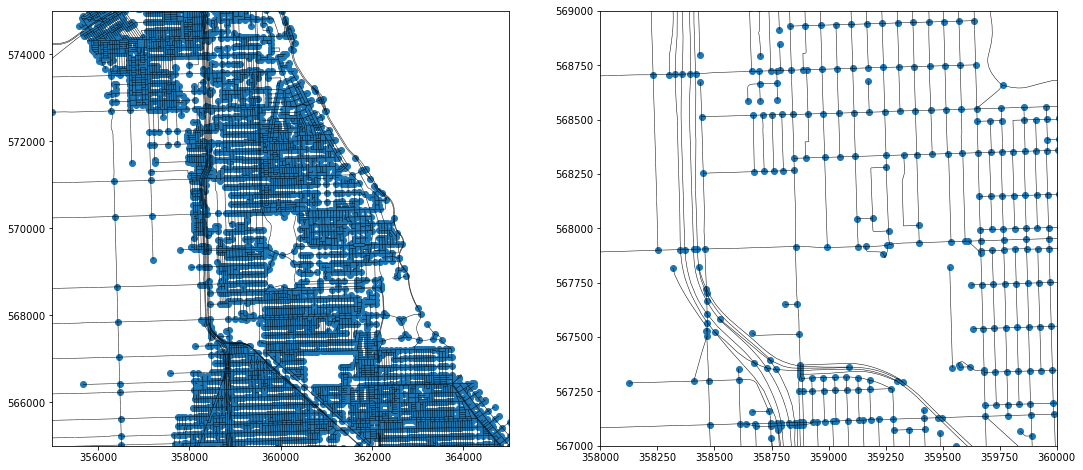

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(18,8))

for ax in axes:
    lc = matplotlib.collections.LineCollection(graph.as_lines(), color="black", linewidth=0.5)
    ax.add_collection(lc)

xcs, ycs = [], []
for k in reduced.vertices:
    xcs.append(graph.vertices[k][0])
    ycs.append(graph.vertices[k][1])
for ax in axes:
    ax.scatter(xcs, ycs)

axes[0].set(xlim=[355000, 365000], ylim=[565000, 575000])
axes[1].set(xlim=[358000, 360000], ylim=[567000, 569000])
None

# Just too many paths!

The underlying problem seems to be that there is just a combinatorial explosion in the number of paths to consider.

- We find a couple of nearby points in a dense maze of streets and avenues.
- Then find how many paths there are from one starting point, of various lengths.
- This is needed for the KDE algorithm-- there is just an explosion in the number of paths to consider as the maximum length increases.

In [6]:
xmin, xmax = 359000, 359200
ymin, ymax = 568500, 568750
[k for k in reduced.vertices if graph.vertices[k][0] >= xmin and graph.vertices[k][0] <= xmax
    and graph.vertices[k][1] >= ymin and graph.vertices[k][1] <= ymax]

[6743, 7359, 17940, 19461, 23879, 25083, 29222]

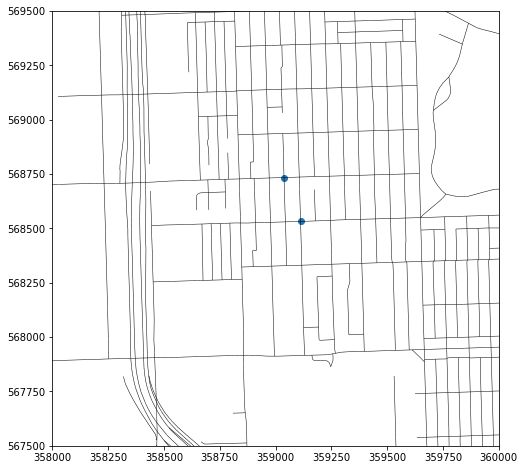

In [7]:
verts = [6743, 17940]

fig, ax = plt.subplots(figsize=(8,8))
lc = matplotlib.collections.LineCollection(graph.as_lines(), color="black", linewidth=0.5)
ax.add_collection(lc)

xcs, ycs = [], []
for k in verts:
    xcs.append(graph.vertices[k][0])
    ycs.append(graph.vertices[k][1])
ax.scatter(xcs, ycs)

ax.set(xlim=[358000, 360000], ylim=[567500, 569500])
None

In [8]:
# Not too many paths between these two vertices...
len(list(graph.paths_between(6743, 17940, 1000)))

43

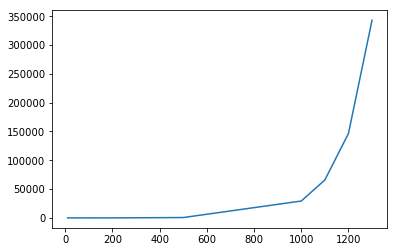

In [9]:
# Explosion in the number of paths to consider for the KDE method...
lengths = [10,20,50,100,200,500,1000,1100,1200,1300]
num_paths = []

for length in lengths:
    nup = len(list(graph.walk_with_degrees(6743, None, length, 10000000000)))
    num_paths.append(nup)
    
plt.plot(lengths, num_paths)

# Some hope

Let's look at an example: pick a nearby edge and see which paths end up crossing it (these are the paths we end up summing in the KDE method to get the final risk estimate).

- We then find that the "cumulative degree" rapidly gets very large
- As we divide by this in the KDE method, we might conjecture that most of these paths are irrelevant.
- This indeed turns out to be the case: most of the summands add very little to the log likelihood.

In [10]:
print(graph.neighbourhood_edges(6743))
print(graph.edges[25201])
print(graph.neighbourhood_edges(13452))

edge = 25202
out = [ path for path in graph.walk_with_degrees(6743, None, 1300, 100000000)
    if path[0] == edge ]
len(out)

[2892, 2893, 25200, 25201]
(6743, 13452)
[25201, 25202]


217

In [11]:
out.sort(key = lambda x : x[3])
out[:5], out[-5:]

([(25202, 41.490110197582254, 68.431643828858185, 3),
  (25202, 472.96907328814666, 499.91060691942261, 54),
  (25202, 475.83059473576679, 502.77212836704274, 81),
  (25202, 608.76693635175036, 635.70846998302625, 324),
  (25202, 606.09726747012235, 633.03880110139824, 486)],
 [(25202, 1281.7162992963026, 1308.6578329275785, 12754584),
  (25202, 1278.4443367161562, 1305.385870347432, 17006112),
  (25202, 1279.0764286403846, 1306.0179622716605, 17006112),
  (25202, 1283.800808655842, 1310.7423422871179, 19131876),
  (25202, 1281.9082053613611, 1308.849738992637, 19131876)])

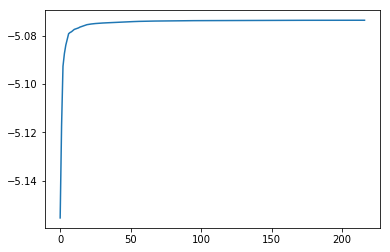

In [12]:
# Example kernel
kernel = open_cp.network_hotspot.TriangleKernel(1500)
out1 = [ kernel.integrate(start, end) / div
    for _, start, end, div in out ]
cumulative_sum = [0]
for x in out1:
    cumulative_sum.append(cumulative_sum[-1] + x)
cumulative_sum = np.asarray(cumulative_sum)
#plt.plot(cummulative_sum)
plt.plot(np.log(cumulative_sum[1:]))

In [13]:
out[25], out[50]

((25202, 1147.6510267824553, 1174.5925604137312, 13122),
 (25202, 1179.5334775598337, 1206.4750111911096, 26244))

# Limiting the maximum degree

If we limit the maximum degree to 20000 then the number of paths to consider begins to tail off, which is hopeful...

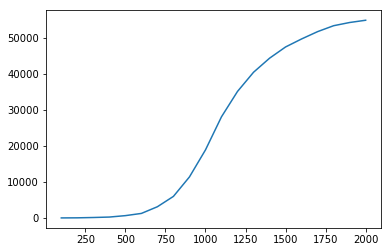

In [14]:
lengths = list(range(100,2100,100))
num_paths = []

for length in lengths:
    nup = len(list(graph.walk_with_degrees(6743, None, length, 20000)))
    num_paths.append(nup)
    
plt.plot(lengths, num_paths)

In [4]:
import pickle, lzma
with lzma.open("Case study Chicago/input.pic.xz", "rb") as f:
    timed_points = pickle.load(f)

trainer = open_cp.network_hotspot.Trainer()
trainer.graph = graph
trainer.maximum_edge_length = 20
trainer.data = timed_points
predictor = trainer.compile()

In [5]:
predictor.graph.number_edges, graph.number_edges

(96168, 40068)

In [6]:
graph.vertices[6743], predictor.graph.vertices[6743]

((359037.44094831066, 568733.8516453756),
 (359037.44094831066, 568733.8516453756))

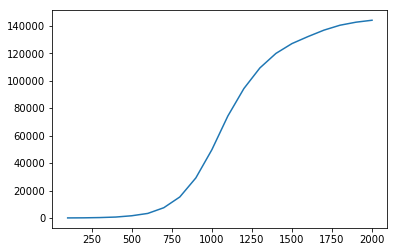

In [7]:
lengths = list(range(100,2100,100))
num_paths = []

for length in lengths:
    nup = len(list(predictor.graph.walk_with_degrees(6743, None, length, 20000)))
    num_paths.append(nup)
    
plt.plot(lengths, num_paths)

# Another approach to caching

On the basis that [Almost all programming can be viewed as an exercise in caching](http://plasmasturm.org/log/542/) lets think a bit more.

- Let's assume that maximum edge length is small compared to spatial scale.
- So there should be little loss in accuracy by assuming all events occur at the mid-point of the edge they lie on
- And we can approximate the "integral" of the kernel by taking it's value at the midpoint and multiply by the length of the edge.

However, we are still left considering _all_ paths between edges, as the way to combine the length of the path, and the product of degrees, depends heavily on the (space) kernel is use.

- So we either cache it all (which is a vast amount of data, probably too much for memory and time).
- Or cache results which are only valid for one kernel.  This doesn't seem like much (or any?) improvement over the caching system I am currently using.

# Approximations

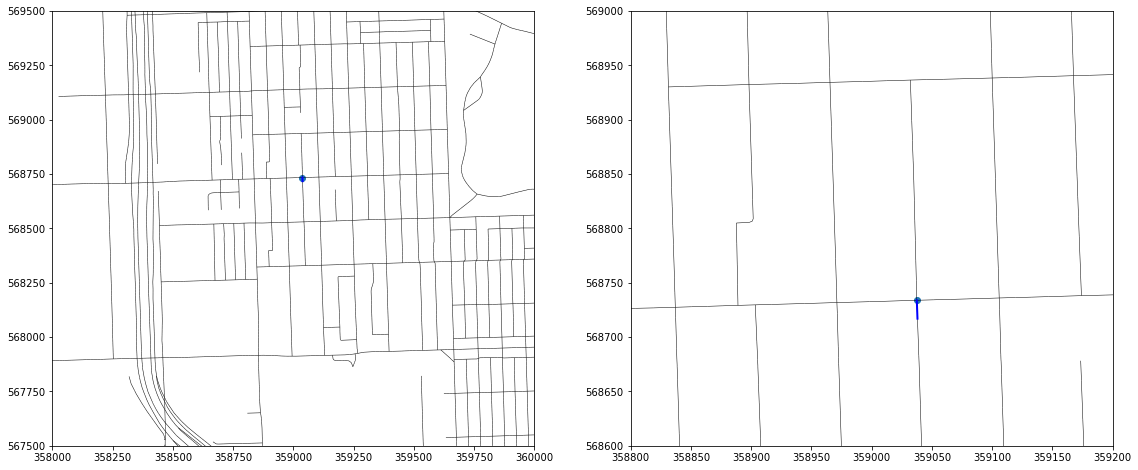

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(19,8))

for ax in axes:
    lc = matplotlib.collections.LineCollection(predictor.graph.as_lines(), color="black", linewidth=0.5)
    ax.add_collection(lc)

    xcs, ycs = [], []
    xcs.append(graph.vertices[6743][0])
    ycs.append(graph.vertices[6743][1])
    ax.scatter(xcs, ycs)

    (x1,y1),(x2,y2) = predictor.graph.as_lines()[8076]
    ax.plot([x1,x2], [y1,y2], color="blue", linewidth=2)

axes[0].set(xlim=[358000, 360000], ylim=[567500, 569500])
axes[1].set(xlim=[358800, 359200], ylim=[568600, 569000])
None

In [9]:
predictor.graph.edges[8076]

(41439, 6743)

In [10]:
predictor.kernel = open_cp.network_hotspot.TriangleKernel(500)
risks = np.zeros(len(predictor.graph.edges))
predictor.add(risks, 8076, -1, 0.5, 1)
predictor.add(risks, 8076, 1, 0.5, 1)
# Remember to normalise!
risks /= predictor.graph.lengths

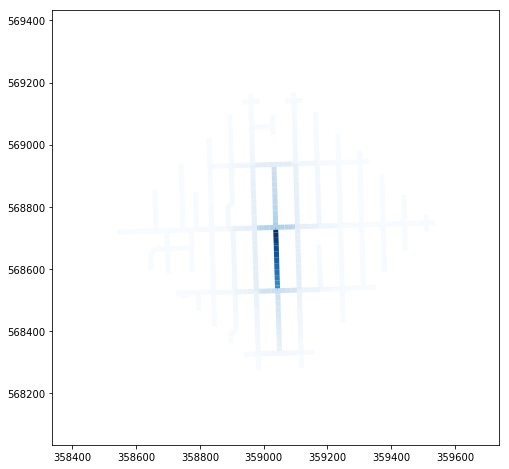

In [11]:
fig, ax = plt.subplots(figsize=(8,8))

lines = np.asarray(predictor.graph.as_lines())
mask = risks > 0
ri, li = risks[mask], lines[mask]
lc = matplotlib.collections.LineCollection(li, color="black", linewidth=5)
lc.set_array(ri)
lc.set(cmap="Blues")
ax.add_collection(lc)
x, y = graph.vertices[6743]
d = 700
ax.set(xlim=[x-d, x+d], ylim=[y-d, y+d])
None

Look at the street edge 8076 is on in more detail.
- The following code finds the edges in the street, stopping at the intersection
- Then we plot the risk, which decays pretty linearly, as hoped.

In [12]:
edges = []
edge = 8076
while True:
    if edge in edges:
        break
    edges.append(edge)
    for k in predictor.graph.edges[edge]:
        nhood = list(predictor.graph.neighbourhood_edges(k))
        nhood.remove(edge)
        if len(nhood) == 1:
            edge = nhood[0]
            break
edges

[8076, 8075, 8074, 8073, 8072, 8071, 8070, 8069, 8068, 8067, 8066, 8065]

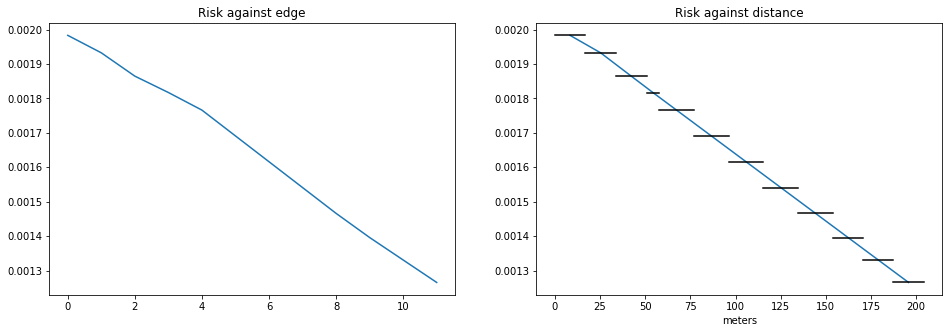

In [13]:
r = [risks[i] for i in edges]
fig, axes = plt.subplots(ncols=2, figsize=(16,5))
ax = axes[0]
ax.plot(r)
ax.set(title="Risk against edge")
ax = axes[1]
x = [0]
for i in edges:
    x.append(x[-1] + predictor.graph.length(i))
x = np.asarray(x)

ax.plot((x[:-1]+x[1:])/2, r)
for i in range(len(x)-1):
    ax.plot([x[i], x[i+1]], [r[i], r[i]], color="black")
ax.set(title="Risk against distance", xlabel="meters")
None

## Compare to distance between edges

- Form the [Derived graph](https://en.wikipedia.org/wiki/Line_graph) and compute distances between the edges
- Compare this to the "risk" our KDE method found above.

**Conclusions:**
- Not a good match
- Especially for larger values of risk, we get multiple correlation lines, as compared to distance.
- This is to be expected, as the KDE methods explicitly takes account of vertex degree.

In [14]:
dgraph = open_cp.network.to_derived_graph(predictor.graph, use_edge_indicies=True)
paths, prevs = open_cp.network.shortest_paths(dgraph, 8076)
assert min(paths.keys()) == 0
assert max(paths.keys()) == len(paths) - 1
paths = [paths[i] for i in range(len(paths))]
paths = np.asarray(paths)

In [15]:
disconnected = paths == -1
assert np.all(risks[disconnected] == 0)
risks, paths = risks[~disconnected], paths[~disconnected]

In [16]:
mask = risks > 0
np.max(paths[mask]), np.min(paths[~mask])

(508.66935231893399, 506.79928159955438)

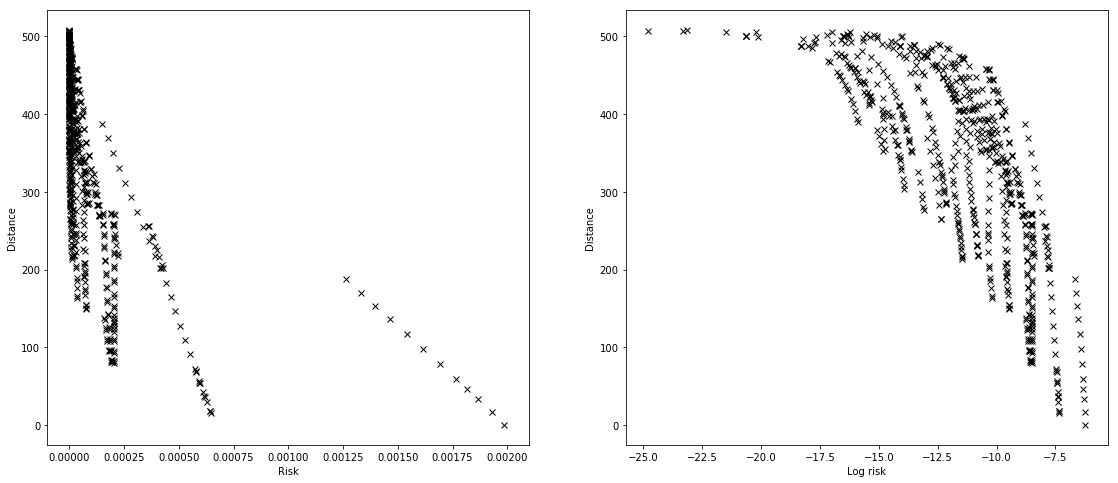

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(19,8))
ax = axes[0]
ax.scatter(risks[mask], paths[mask], marker="x", linewidth=1, color="black")
ax.set(xlabel="Risk", ylabel="Distance", xlim=[-0.0001, 0.0021])
ax = axes[1]
ax.scatter(np.log(risks[mask]), paths[mask], marker="x", linewidth=1, color="black")
ax.set(xlabel="Log risk", ylabel="Distance")
None

## Take account of vertex degree

An obvious tactic is to compute the shortest path distance, but taking account of the vertex degree in the same way the KDE method does.  Unfortunately, performing this calculation in the derived graph is wrong (draw a few example graphs...)

In [18]:
risks = np.zeros(len(predictor.graph.edges))
predictor.add(risks, 8076, -1, 0.5, 1)
predictor.add(risks, 8076, 1, 0.5, 1)
risks /= predictor.graph.lengths

k1, k2 = predictor.graph.edges[8076]
paths1, prevs1 = open_cp.network.shortest_paths(predictor.graph, k1)
paths2, prevs2 = open_cp.network.shortest_paths(predictor.graph, k2)
paths1 = np.asarray([paths1[i] for i in range(len(paths1))])
paths2 = np.asarray([paths2[i] for i in range(len(paths2))])
paths, prevs = open_cp.network.shortest_paths(dgraph, 8076)
paths = np.asarray([paths[i] for i in range(len(paths))])
epaths, eprevs = open_cp.network.shortest_edge_paths(predictor.graph, 8076)

In [19]:
def shortest(edge_index):
    k1, k2 = predictor.graph.edges[edge_index]
    halves = (predictor.graph.length(edge_index) + predictor.graph.length(8076)) / 2
    choices = [paths1[k1], paths1[k2], paths2[k1], paths2[k2]]
    le = min(choices)
    index = choices.index(le)
    return le + halves, index

edge = 8010
k1, k2 = predictor.graph.edges[edge]
le = predictor.graph.length(edge) / 2
shortest(edge), paths[edge], min(epaths[k1]+le, epaths[k2]+le)

((1205.4162437056104, 3), 1205.4162437056102, 1205.4162437056104)

In [20]:
def degree_of_shortest_path(edge_index):
    k1, k2 = predictor.graph.edges[edge_index]
    kk1, kk2 = predictor.graph.edges[8076]
    _, choice = shortest(edge_index)
    if choice == 0:
        vertex, pa = k1, prevs1
    elif choice == 1:
        vertex, pa = k2, prevs1
    elif choice == 2:
        vertex, pa = k1, prevs2
    elif choice == 3:
        vertex, pa = k2, prevs2
    else:
        raise AssertionError
    
    v = vertex
    cum_deg = max(1, predictor.graph.degree(v) - 1)
    while True:
        vv = pa[v]
        if v == vv:
            break
        v = vv
        d = max(1, predictor.graph.degree(v) - 1)
        cum_deg *= d
    return cum_deg

degree_of_shortest_path(8010)

1259712

In [21]:
adjusted_dists = np.empty_like(risks)
for i, r in enumerate(risks):
    if r == 0:
        continue
    adjusted_dists[i], _ = shortest(i)
    adjusted_dists[i] = predictor.kernel(adjusted_dists[i])
    adjusted_dists[i] = adjusted_dists[i] / degree_of_shortest_path(i)

mask = (risks > 0)
r = risks[mask]
adjusted_dists = adjusted_dists[mask]

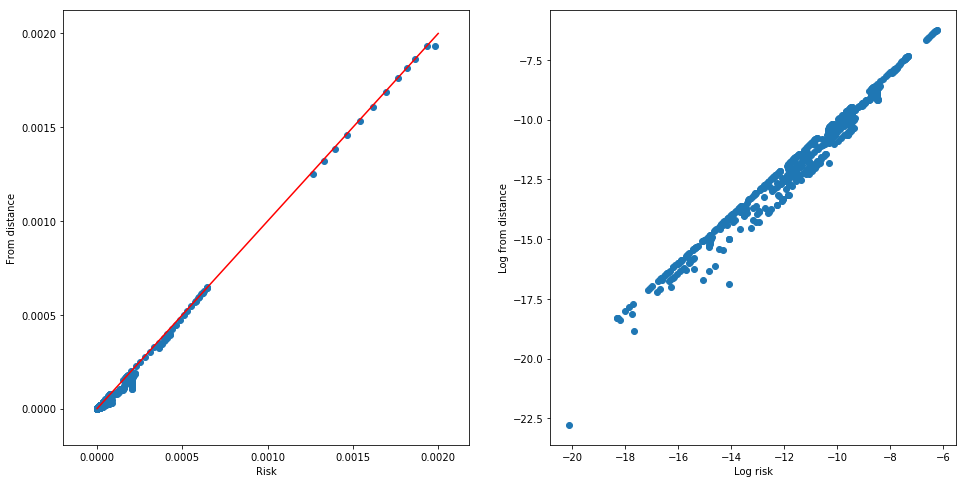

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
ax = axes[0]
ax.scatter(r, adjusted_dists)
ax.set(xlabel="Risk", ylabel="From distance")
xmin, xmax = 0, max(r)
xd = (xmax - xmin) / 10
ymin, ymax = 0, max(adjusted_dists)
yd = (ymax - ymin) / 10
ax.set(xlim=[xmin-xd, xmax+xd], ylim=[ymin-yd, ymax+yd])
x = np.linspace(0, 0.002, 2)
ax.plot(x, x, color="red")

ax = axes[1]
mask = (r>0) & (adjusted_dists>0)
ax.scatter(np.log(r[mask]), np.log(adjusted_dists[mask]))
ax.set(xlabel="Log risk", ylabel="Log from distance")
None

In [23]:
pred = open_cp.network_hotspot.ApproxPredictor(predictor)
risks_approx = np.zeros(len(predictor.graph.edges))
pred.add_edge(risks_approx, 8076, 0.5, 1)
risks_approx /= predictor.graph.lengths

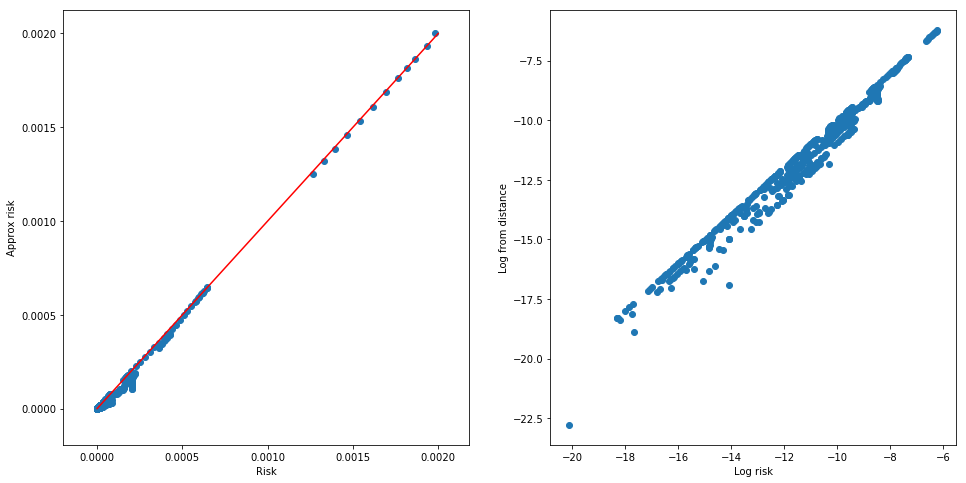

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8))
ax = axes[0]
ax.scatter(risks, risks_approx)
ax.set(xlabel="Risk", ylabel="Approx risk")
xmin, xmax = 0, max(r)
xd = (xmax - xmin) / 10
ymin, ymax = 0, max(adjusted_dists)
yd = (ymax - ymin) / 10
ax.set(xlim=[xmin-xd, xmax+xd], ylim=[ymin-yd, ymax+yd])
x = np.linspace(0, 0.002, 2)
ax.plot(x, x, color="red")

ax = axes[1]
mask = (risks>0) & (risks_approx>0)
ax.scatter(np.log(risks[mask]), np.log(risks_approx[mask]))
ax.set(xlabel="Log risk", ylabel="Log from distance")
None